<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020/blob/main/CNN_with_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified version of:
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb 



### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. The state of the art accuracy is about 99 percent.


In [48]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

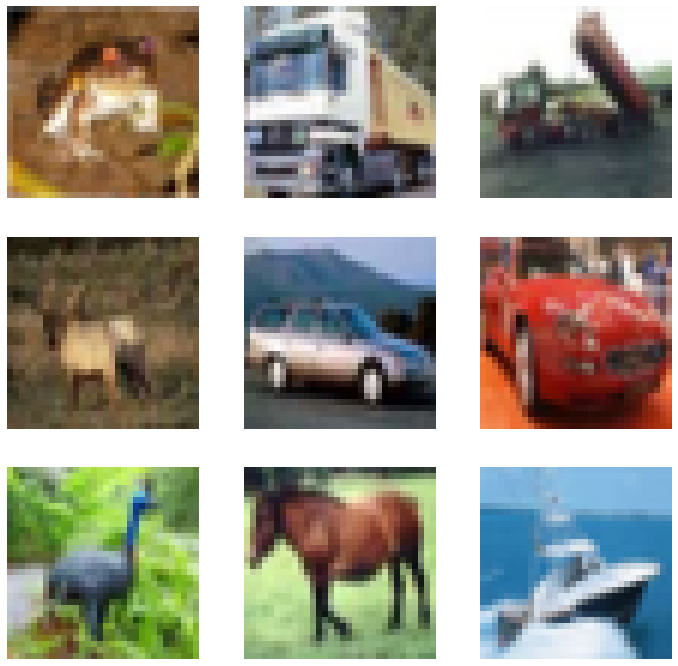

In [49]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3

# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i])
plt.show()

In [50]:
# set up image augmentation
datagen = ImageDataGenerator( 
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25
    )
datagen.fit(x_train)

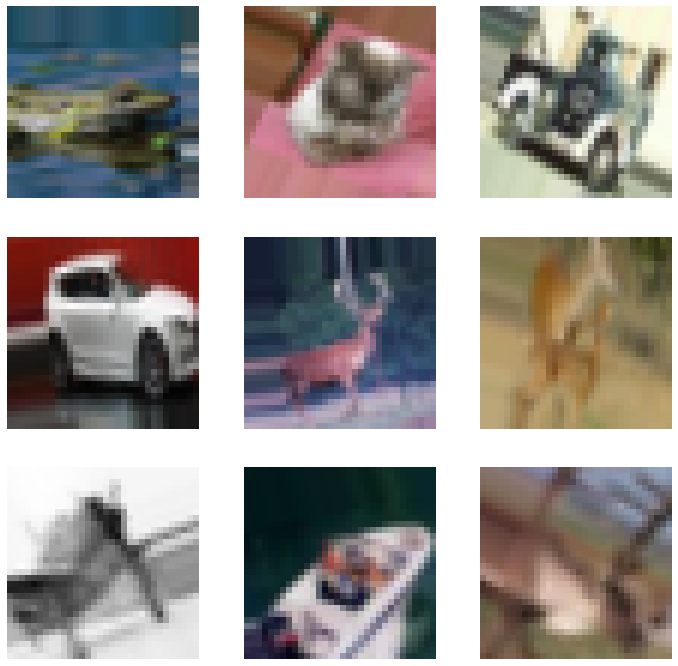

In [51]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].astype(np.uint8))
         plt.axis('off')
    plt.show()
    break

   

Augmentation of a single image

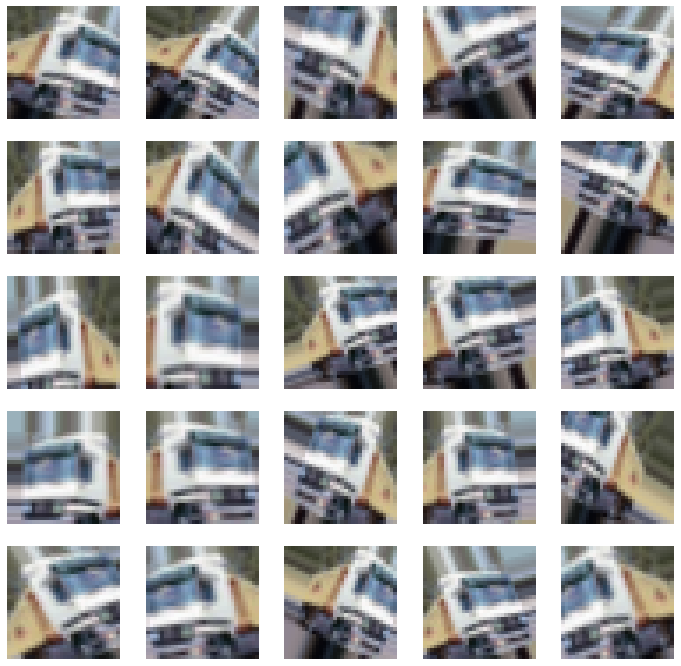

In [52]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()
    


In [53]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [54]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [55]:
 # labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [56]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)       

In [58]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 5s 12ms/step - loss: 1.5099 - accuracy: 0.5047 - val_loss: 1.2032 - val_accuracy: 0.5876
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 0.8789 - accuracy: 0.6925 - val_loss: 0.8245 - val_accuracy: 0.7157
Epoch 3/100
391/391 [==============================] - 4s 11ms/step - loss: 0.6883 - accuracy: 0.7607 - val_loss: 0.7072 - val_accuracy: 0.7573
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5664 - accuracy: 0.8018 - val_loss: 0.6760 - val_accuracy: 0.7705
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 0.4854 - accuracy: 0.8309 - val_loss: 0.6416 - val_accuracy: 0.7851
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 0.4094 - accuracy: 0.8570 - val_loss: 0.7089 - val_accuracy: 0.7749
Epoch 7/100
391/391 [==============================] - 4s 11ms/step - loss: 0.3343 - accuracy: 0.8837 - val_loss: 0.6585 - val_accuracy:

In [59]:
#training accuracy without dropout
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc

391/391 [==============================] - 2s 4ms/step - loss: 0.0049 - accuracy: 0.9984


[0.004919077269732952, 0.9983800053596497]

In [60]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

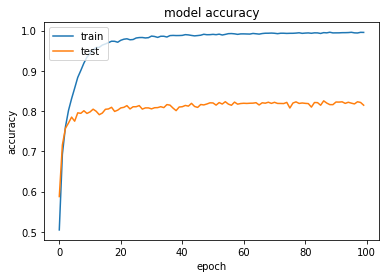

In [61]:
plothist(history)

In [62]:
#model.save('cifar10_01.h5')                  
#model=load_model('cifar10_01.h5')

In [63]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Flatten())
model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

In [64]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)       

In [65]:
# train with image augmentation
history2=model2.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
391/390 [==============================] - 23s 59ms/step - loss: 1.9378 - accuracy: 0.3646 - val_loss: 1.3676 - val_accuracy: 0.5126
Epoch 2/200
391/390 [==============================] - 23s 58ms/step - loss: 1.4194 - accuracy: 0.4929 - val_loss: 1.1665 - val_accuracy: 0.5922
Epoch 3/200
391/390 [==============================] - 23s 58ms/step - loss: 1.2196 - accuracy: 0.5654 - val_loss: 1.1196 - val_accuracy: 0.6239
Epoch 4/200
391/390 [==============================] - 23s 58ms/step - loss: 1.1048 - accuracy: 0.6091 - val_loss: 1.5690 - val_accuracy: 0.5631
Epoch 5/200
391/390 [==============================] - 22s 57ms/step - loss: 1.0139 - accuracy: 0.6418 - val_loss: 0.8487 - val_accuracy: 0.7088
Epoch 6/200
391/390 [==============================] - 23s 58ms/step - loss: 0.9451 - accuracy: 0.6706 - val_loss: 0.8568 - val_accuracy: 0.7082
Epoch 7/200
391/390 [==============================] - 23s 58ms/step - loss: 0.8947 - accuracy: 0.6901 - val_loss: 0.8964 - val_ac

In [66]:
#model2.save('cifar10_02.h5')         # about 90% accuracy

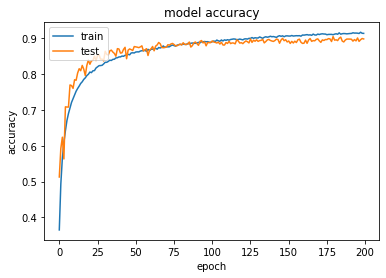

In [67]:
plothist(history2)  # 128 batch, 0.001 lr, 

In [68]:
print(x_test.shape,y_test.shape)
model2_test_acc=model2.evaluate(x_test,y_test,batch_size=128)
model2_test_acc

(10000, 32, 32, 3) (10000, 10)
79/79 [==============================] - 0s 4ms/step - loss: 0.3260 - accuracy: 0.8986


[0.3259532153606415, 0.8985999822616577]

In [69]:
model2_train_acc=model2.evaluate(x_train,y_train,batch_size=128)
model2_train_acc

391/391 [==============================] - 2s 4ms/step - loss: 0.1140 - accuracy: 0.9604


[0.11396455019712448, 0.9604399800300598]

# **Plot images**

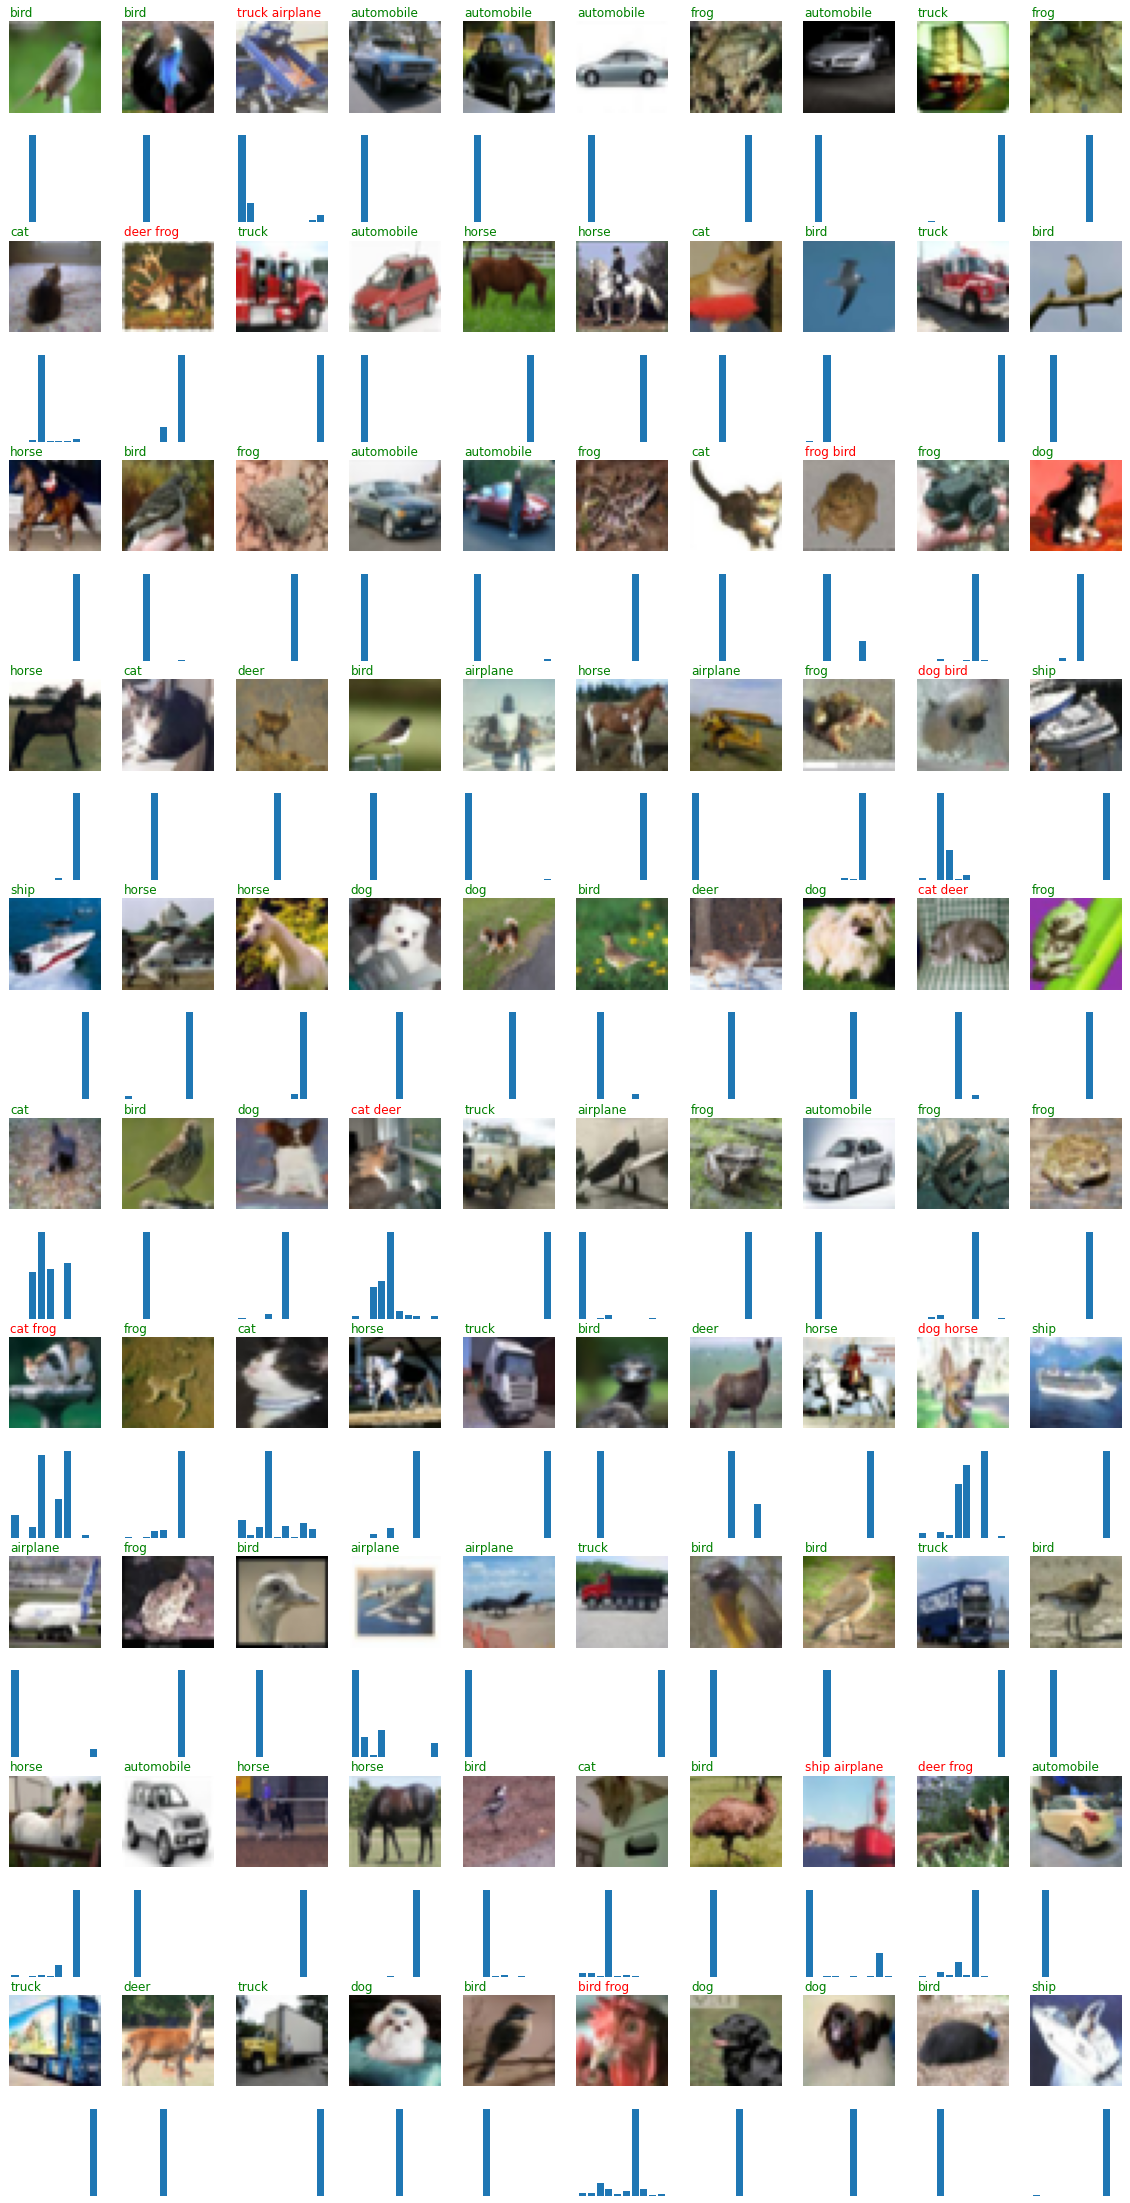

In [94]:
# Names of predicted classes (randomly chosen images)

import random


class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

y_pred = model2.predict_classes(x_test)
y_pred_prob = model2.predict(x_test)

grid_w = 10
grid_h = 10

fig = plt.figure(figsize=(20, 40))
for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    plt.bar([0,1,2,3,4,5,6,7,8,9],y_pred_prob[i_img])
    plt.axis('off')

plt.show()

In [71]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model2.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



313/313 - 1s
[[926   3  16   3   4   0   8   6  15  19]
 [  5 971   0   0   0   0   0   2   4  18]
 [ 16   3 886  18  15   5  37  10   5   5]
 [ 11   8  29 776  28  65  50  20   5   8]
 [  8   2  24  17 883   7  36  17   2   4]
 [  1   5  24  78  21 803  25  34   3   6]
 [  8   1  16  11   3   0 956   4   0   1]
 [  4   0  10   4  18  14   5 940   0   5]
 [ 41  18   5   2   0   0   3   1 908  22]
 [ 10  44   0   0   0   0   0   0   9 937]]
